# Nuclear Data module introduction and the ENDF format

This notebook does not require you to write any code, it is just a low level introduction helpful to perform the other notebooks. You do not need to submit this one.

In order to perform neutronics calculations one requires nuclear data. In the introductory datalabs we have relied on eg. neutron-induced reaction cross sections, nubar data, etc. Nevertheless, our method to obtain such data was to visit either [NDS-IAEA](https://www-nds.iaea.org/) or [KAERI's nuclide chart](https://atom.kaeri.re.kr/nuchart/), then select the appropriate cross section, download a point-wise (ie. energy-cross section value pairs) format, and visualize or process it to some extent. With this however we have only touched the surface of nuclear data. In fact, nuclear data is not usually stored or used in this format, since this is only convenient for plotting. Also when nuclear data is being used in simulations, it first needs to be processed into an appropriate format. If working with Monte Carlo simulations, this is most often the ACE point-wise format (note that in openMC we have relied on h5 files, which can be converted from ACE files). If working with deterministic simulations, the format depends on the code, however the data is in a group-wise format.

The aim of this module is to deepen our understanding on how nuclear data is stored, what it contains and how it can be processed with simple python code. We will not become nuclear data experts, but will gain the necessary knowledge for a neutronics specialist or a nuclear engineer, and the interested students will have a strong foundation to deepen their knowledge further with little effort. However, the most valuable added benefit of learning and working with nuclear data is that you learn about nuclear physics as well, which will in return clarify for us why certain approximations are used in reactor physics. 

My personal motivation to create this module was that over the years while working and teaching neutronics, I have noticed that nuclear data processing is often overlooked. While trying to clarify these questions for myself, I have realized that it is difficult to find a transparent, easy to understand material on the subject. The best sources I came across were the ["An Introduction to the ENDF Formats"](https://t2.lanl.gov/nis/endf/) and the ["Understanding NJOY"](https://t2.lanl.gov/nis/njoy/) learning modules from LANL T2's Nuclear Information Services. My intention was to complement these modules with Jupyter notebooks which transparently demonstrate how steps of the nuclear data processing pipeline can be implemented.

The strategy of this learning module is that we implement the simplest methods and approximations to process raw nuclear data (such as resonance reconstruction or Doppler broadening), which will allow us to understand why and how a nuclear data processing is needed. Then more as illustration than actual exercise we review more advanced topics.

The content of the module is:
0. Intro and the ENDF format
1. Point-wise and group-wise cross sections
2. Reconstructing resonances: single-level Breit-Wigner formalism
3. Doppler broadening of resonances
4. Self-shielding: group cross sections with narrow resonance model
5. Angular distributions
6. Thermal scattering laws
7. Unresolved resonance region
8. Nuclear data covariances
9. Other beasts: gas production, KERMA, damage energy (to be finalized)
10. Using NJOY (to be finalized)

So let's get familiar with the ENDF format in this notebook, we will not do too much coding, in fact you do not need to run anything here, but still, it's exciting!

# The ENDF format

Nuclear data was organized into libraries or files to facilitate distribution by various national labs world wide. These efforts made use of different formats. The US national nuclear data file was called ENDF/B (the Evaluated Nuclear Data Files), and after a while other nuclear data files (eg. JEFF from Europe and JENDL from Japan) have adopted the format of ENDF/B. Therefore now, somewhat confusingly we refer to the format as ENDF (ENDF-6 to be precise, since the format itself has also evolved), and we refer the US national nuclear data file as ENDF/B (with the most up to date version being ENDF/B-VIII.1). It has to be mentioned however that the development of the ENDF format started in the 1960s, and although it evolved over the years, it has some shortcomings: eg. as we will see, it is not an entirely user-friendly format, making it difficult to parse it for new users, and the numeric precision is also limited.  Therefore, during the last decade substantial work has begun by the nuclear data community lead by OECD NEA to develop a new, xml-based format called [Generalized Nuclear Data Structure (GNDS)](https://www.oecd-nea.org/jcms/pl_39689/specifications-for-the-generalised-nuclear-database-structure-gnds?details=true). For the time being however, the use of ENDF is still widely accepted, therefore this module also focuses on that. 

The national data files rely on different evaluations and experiments, therefore running the same computation might produce different results for various nuclear data. This actually gives the main motivation to work on improving nuclear data, since no matter how accurately a code describes the physics, the quality of the data is going to have a large influence on the accuracy of the computations.

Here we will have only a low-level indtroduction to the ENDF file format, since we do not intend to work directly with this format. A higher-level tutorial can be found at [LANL T2](https://t2.lanl.gov/nis/endf/), or further clarifications can be found in the [documentation of the format](https://www.nndc.bnl.gov/csewg/docs/endf-manual.pdf).

When you have downloaded cross sections from the [NDS-IAEA](https://www-nds.iaea.org/) or [KAERI's nuclide chart](https://atom.kaeri.re.kr/nuchart/), you might have noticed that there is an option to download or retrieve the full text.

At IAEA-NDS one can retrieve either selected data, or with the `ENDF6` button, the given section. Next to this button is an other one titled `Interpreted`. In fact, most of the time we will work with that interpreted format, which is more easily digestable.

![](figures/NDS_retrieve.png)

At KAERI, by clicking on the `Full text` you can retrieve the whole ENDF file. However, keep in mind that this file can be rather large.

![](figures/KAERI_fulltext.png)

In the `/data` folder one can find an ENDF/B-VII.1 tape of Uranium-238 downloaded from [LANL T2](https://t2.lanl.gov/nis/data/endf/endfvii.1-n.html) named `U238.endf` (note that the file is an ASCII file, it is not required that it has an `.endf` extension, it is just named so to distinguish it from other files in the folder with similar names). Let's read in the first 50 lines with the use of `readlines()` and the the string `join()` method.

In [1]:
with open('data/U238.endf', 'r') as endf:
    print(''.join(endf.readlines()[0:50]))

 $Rev:: 532      $  $Date:: 2011-12-05#$                             1 0  0    0
 9.223800+4 2.360058+2          1          1          0          59237 1451    1
 0.000000+0 1.000000+0          0          0          0          69237 1451    2
 1.000000+0 3.000000+7          1          0         10          79237 1451    3
 0.000000+0 0.000000+0          0          0        734        1279237 1451    4
 92-U -238 ORNL,LANL+ EVAL-SEP06 Young,Chadwick,Derrien,Courcelle 9237 1451    5
                      DIST-DEC06 REV2-                 20111222   9237 1451    6
----ENDF/B-VII.1      MATERIAL 9237         REVISION 2            9237 1451    7
-----INCIDENT NEUTRON DATA                                        9237 1451    8
------ENDF-6 FORMAT                                               9237 1451    9
***************************************************************** 9237 1451   10
12/09/2010  S.T. Holloway on behalf of LANL                       9237 1451   11
  Reverted MF=1/5, MT=455 De

Well, this doesn't look half bad, text written in plain English, and only on the side do we see some cryptic parameters `9237 1451`. In order to make sense of these values we have to review the three main stages of the ENDF-6 format structure.

![](figures/ENDFstructure.png)

ENDF files contain a *material*, which can be a nuclide (ground state or excited state), an element containing several isotopes, or a mixture of elements, and is described by its MAT number. Under the material several *files* are available described by MF numbers, which contain physical quantities (for example the cross sections). And each file contains several *sections* described by an MT number (for example reaction channels). And in the sections is the data stored (either as a one or two dimensional tabulated function, such as (energy, cross section) pairs with an interpolation scheme, or parameters of functions, such as parameters of a resonance (location, width). Further details on the MAT, MF and MT numbers can be found in the [documentation](https://www.oecd-nea.org/jcms/pl_39689/specifications-for-the-generalised-nuclear-database-structure-gnds?details=true), here we summarize only the few which will be relevant for our further exercises, and at the appropriate place we will intoduce some other ones:

MF numbers:
- MF 1: General information
- MF 2: Resonance parameter data
- MF 3: Reaction cross sections
- MF 6: Energy-angle distributions of emitted particles
- MF 7: Thermal neutron scattering law data

MT numbers (note that not all files have the same MT numbers):
- MT 1: total reaction: sum of other MT sections
- MT 2: elastic scattering
- MT 18: total fission
- MT 102: radiative capture
- MT 151: resonance parameters
- MT 451: documentation

With that we can already figure out that in the first few lines of the `U238.endf` file, `1451` refers to MF=1 MT=451, and in fact for Uranium-238 MAT=9237. If the MT has less characters, then there is a white space between MF and MT (you remember, this is an unfriendly format).

Let's print now the content of the file from line 6832-6839 (we happen to know that the radiative capture cross section data sits there). For this we will use the `readlines()` and the string `join()` method as before. Note that in python indexing goes from 0, hence the starting index is 6831.

In [2]:
with open('data/U238.endf', 'r') as endf:
    print(''.join(endf.readlines()[6831:6869]))

 9.223800+4 2.360058+2          0          0          0          09237 3102    1
 4.806500+6 4.806500+6          0          0          1        1019237 3102    2
        101          2                                            9237 3102    3
 1.000000-5 0.000000+0 2.000000+4 0.000000+0 2.000000+4 5.274300-19237 3102    4
 2.300000+4 4.989200-1 2.600000+4 4.732700-1 3.000000+4 4.434000-19237 3102    5
 3.500000+4 4.109100-1 4.000000+4 3.826300-1 4.500000+4 3.582300-19237 3102    6
 4.509025+4 3.578200-1 5.000000+4 3.250600-1 5.500000+4 2.984700-19237 3102    7
 6.000000+4 2.755600-1 7.000000+4 2.397900-1 8.000000+4 2.138100-19237 3102    8
 9.000000+4 1.943600-1 1.000000+5 1.793600-1 1.200000+5 1.596600-19237 3102    9
 1.400000+5 1.467600-1 1.490288+5 1.424500-1 1.600000+5 1.378700-19237 3102   10
 1.700000+5 1.343200-1 1.800000+5 1.313000-1 1.900000+5 1.287300-19237 3102   11
 2.000000+5 1.265400-1 2.100000+5 1.244700-1 2.200000+5 1.225200-19237 3102   12
 2.300000+5 1.209800-1 2.350

We notice immedietly, that our cryptic numbers become now `9237 3102` which stand for MAT=9237 MF=3 MT=102, which based on our summary list is the radiative capture cross section on Uranium-238. The other thing we notice is that the numbers are given in a strange scientific notation eg. `1.900000+7`, this we will overcome with some python, when needed. 

We also notice that there is a strict format here: The first 66 letters of a row contain data, the next 4 letters are reserved for the MAT number (which is typically 3 or 4 characters long). Then 2 characters are reserved for MF numbers, 3 characters reserced for the MT numbers, and finally 5 characters reserved for the line number.

Line 1 (see the last number of the row) is a HEAD record, which gives the ZAID (1000\*92+238) of the nuclide, followed by the mass of the nucleus (given as AWR: the ratio of the mass of the material to that of the neutron). The last line is a "SEND" record, which signals the end of the section (there are FEND, MEND and TEND records as well to signal the end of a file, material and tape), and everyting in between is a "TAB1" record for one-dimensional data. There are other possible records, which you can find in the documentation if needed.

Line 2 contains the [Q-Values](https://www-nds.iaea.org/exfor/servlet/efhelp/qmqi.html), which is are `4.806500+6`.

Line 3 describes the number of (energy,cross section) pairs, 101 in this case. And the [interpolation law](https://www-nds.iaea.org/exfor/servlet/efhelp/interp.html), which is 2, meaning linear-linear interpolation.

Then Line 4-37 contain the (energy,cross section) pairs. This is not so much data what we are used to when plotting point-wise cross sections, right? Yes, indeed, because in order to get the point-wise data, one needs to reconstruct the content of the ENDF file, based on the interpolation law, and on resonance parameters.

Let's open the section with resonance parameters, or at least a few lines of it since this section is several thousand lines (U-238 is a resonant nuclide).

In [3]:
with open('data/U238.endf', 'r') as endf:
    print(''.join(endf.readlines()[904:935]))

 9.223800+4 2.360058+2          0          0          1          09237 2151    1
 9.223800+4 1.000000+0          0          0          2          09237 2151    2
 1.000000-5 2.000000+4          1          3          0          09237 2151    3
 0.000000+0 9.480000-1          0          0          2          29237 2151    4
 2.360060+2 9.480000-1          0          0       5556        9269237 2151    5
-4.405250+3 5.000000-1 1.393500+2 2.300000-2 0.000000+0 0.000000+09237 2151    6
-4.133000+2 5.000000-1 5.215449-2 2.300000-2 0.000000+0 0.000000+09237 2151    7
-3.933000+2 5.000000-1 4.993892-2 2.300000-2 0.000000+0 0.000000+09237 2151    8
-3.733000+2 5.000000-1 4.764719-2 2.300000-2 0.000000+0 0.000000+09237 2151    9
-3.533000+2 5.000000-1 4.527354-2 2.300000-2 0.000000+0 0.000000+09237 2151   10
-3.333000+2 5.000000-1 4.281115-2 2.300000-2 0.000000+0 0.000000+09237 2151   11
-3.133000+2 5.000000-1 4.025348-2 2.300000-2 0.000000+0 0.000000+09237 2151   12
-2.933000+2 5.000000-1 3.759

We are not going into too much detail for the moment, since there will be a datalab, where we will work with resonance parameters. If the same section is opened with IAEA-NDS, the following information is given as header:

```
    Number of isotopes represented: 1

    Isotope number: 1
    Isotope ZA: 92238.
    Isotope abundance: 1.0000
    Number of energy ranges: 2

    Energy range number: 1
    Lower energy limit: 1.000000-5
    Upper energy limit: 2.000000+4

    Reich-Moore Parameters

    Spin: 0.0
    Scattering length AP: 0.94800
    4*pi*AP**2: 11.2934 barns
    Number of l states: 2

    Resonance Parameters for l= 0
    L-dependent scattering radius: 0.94800 
```

Then from Line 6 we have the resonance parameters in the columns as

Energy (eV), spin J, and widths GN (neutron width), GG (radiation width), GFA (first partial fission width), GFB (second partial fission width). Later we will reconstruct resonances with these parameters, but for the moment we let them be.

We can notice that the first few resonances are negative resonances (come at negative energies), and we might recognize the notable resonance of U-238 at 6.67 eV in Line 28.

# Parsing ENDF

As mentioned before, we will not bother with using ENDF data directly, you will be given files containing interpreted data to work with.

Nevertheless it is worth mentioning that the team developing NJOY has also distributed a toolkit, [ENDFtk](https://github.com/njoy/ENDFtk/), which is capable of parsing ENDF formatted data. We will review the basic functionality of this toolkit. (Note, you do not need to execute this cell, however if you want, this toolkit needs to be installed if you are not using the distributed Ubuntu machine with preinstalled software. The installation is straightforward, just follow the instructions at the link above).


In [4]:
import numpy as np 
import matplotlib.pyplot as plt

#import sys  #depending on your install you might need to set a path
#sys.path.append('/yourpath/ENDFtk/build')
import ENDFtk

Now, we will need to open a "tape" from the file, and then we will parse the appropriate section:

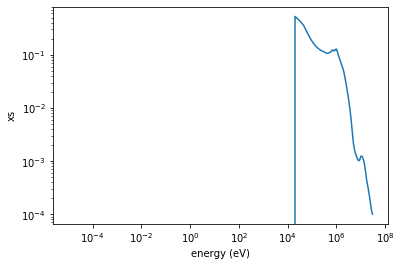

In [5]:
tape = ENDFtk.tree.Tape.from_file( 'data/U238.endf' )
section = tape.material(9237).file(3).section(102).parse()

xs=np.array(section.cross_sections,dtype=float)
energy=np.array(section.energies,dtype=float)


plt.figure()
plt.loglog(energy,xs)
plt.xlabel('energy (eV)')
plt.ylabel('xs')
plt.show()

Huh, this is not something we are used to! Indeed, this is the raw data as we saw above, and not the reconstructed cross section. But don't worry, we will do that soon enough in an other notebook.